# Proyecto Spotify Song Predictor
### Aprendizaje Automático, Universidad Complutense de Madrid


- **Eladia Gómez Morales**
- **Ana Martínez Sabiote**

## 1. Presentación del dataset

El siguiente proyecto trata de clasificar si me gustan o no canciones, de acuerdo a sus características musicales y auditivas.
Dataset: https://www.kaggle.com/datasets/geomack/spotifyclassification

In [3]:
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [4]:
datos = pd.read_csv('data.csv')

Primero, revisamos como es el dataFrame del dataset de spotify, procedente de kaggle, que hemos cargado en nuestro notebook. Para ello, utilizamos la funcion head() de pandas, la cual devuelve las primeras n filas (5 por defecto) de dataFrame. De esta manera revisamos que tiene el tipo adecuado y podemos reflexionar sobre el preprocesamiento que debemos realizar a estos datos.

In [5]:
datos.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [6]:
print(datos.shape)

(2017, 17)


## 2. Preprocesamiento de datos

Nuestro dataset tiene 2017 filas y 17 columnas. Lo primero que tenemos que hacer es comprender y familiarizarnos con nuestro dataset para entrar en el dominio del problema.

- Observamos que la columna "target", llamada generalmente label en el transcurso de este curso, toma valores 0 y 1. Hemos inspeccionado el dataset y hemos observado que las primeras 1021 filas corresponden al label 1 y las sucesivas al label 0. Es necesario ordenar aleatoriamente las filas del dataset.
- Vamos a cambiar las unidades de la columna 'duration_ms' de milisegundos a minutos y vamos a cambiar el nombre de dicha columna para que sea representativo ("duration_min")
- Vamos a eliminar la primera columna (unnamed, que ordena los datos del dataset), la penúltima columna - 16, ("song_title", es decir, título de la canción) y la última columna - 17 ("artist", cantante o grupo de dicha canción). Hemos decidido eliminar estas columnas ya que no vamos a usar estos datos para realizar la clasificación, ya que no ayudan. Preferimos tener variables categóricas (se decía así??)

In [7]:
# Transformamos duration_ms a duration_min
datos["duration_ms"] = (1/60000) * datos["duration_ms"]
datos = datos.rename(columns={'duration_ms': 'duration_min'})

# Eliminamos la columna 0, 16 y 17.
datos=datos.iloc[:,1:15]

# Ordenamos aleatoriamente las filas del dataset
datos = datos.sample(frac=1)

In [8]:
datos.head()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
1860,0.7010,0.447,2.850767,0.288,0.000002,4,0.0915,-9.131,1,0.0298,139.522,4.0,0.3520,0
1210,0.0183,0.745,3.165983,0.714,0.000000,1,0.0636,-5.501,0,0.0302,120.025,4.0,0.8470,0
733,0.6490,0.288,2.860333,0.394,0.712000,7,0.1450,-14.352,1,0.0399,151.632,3.0,0.0733,1
952,0.7580,0.744,2.822217,0.555,0.000000,3,0.1080,-6.744,1,0.0321,121.241,4.0,0.7750,1
1375,0.2530,0.743,3.959800,0.886,0.002670,8,0.7140,-3.503,0,0.0831,109.961,4.0,0.3970,0


In [9]:
print(datos.shape)

(2017, 14)


In [10]:
datos.describe()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,4.105103,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,1.366364,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,0.267367,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,3.333583,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,3.821017,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,4.505550,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,16.743783,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


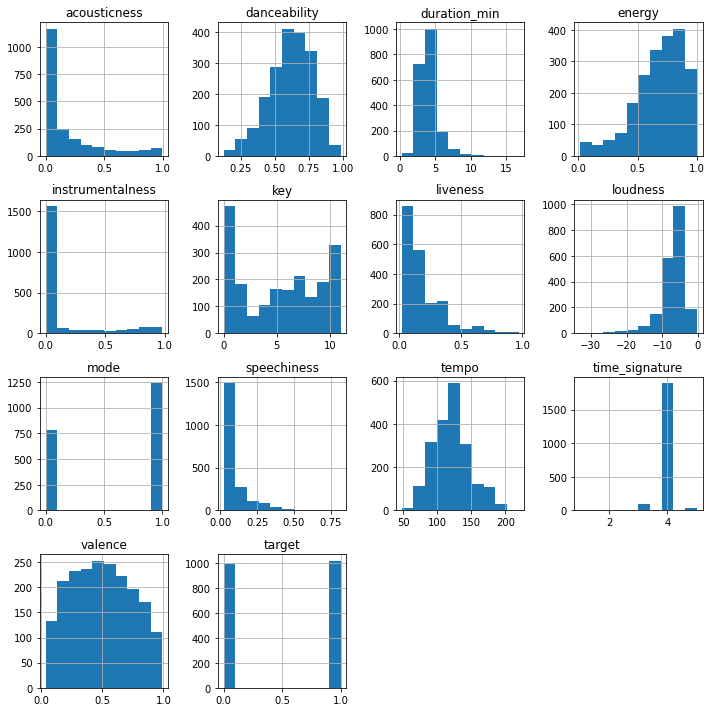

In [11]:
datos.hist(figsize=(10, 10)) 
plt.tight_layout()

<AxesSubplot:>

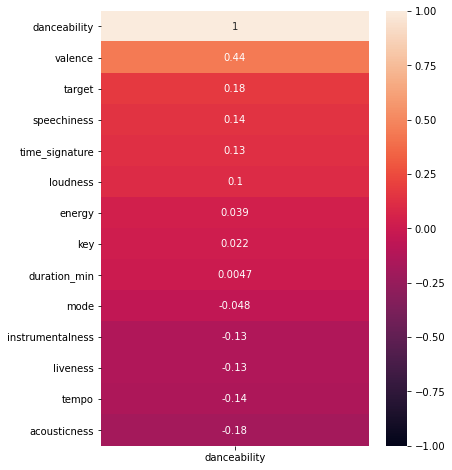

In [12]:
plt.figure(figsize=(6, 8)) 
tempdf = datos.corr()[['danceability']].sort_values('danceability', ascending=False).iloc[:20, :] 
sns.heatmap(tempdf, annot=True, vmin=-1, vmax=1)

- Normalización - QUIZÁS SÍ
- Bucketización - NO LO NECESITAMOS (para tempo y para duration?)
- Categorización (One hot encoding) - SÍ, PARA KEY y time signature!!!
- Outliers, valores raros - QUIZÁS SÍ
- Missing values 
- Correlaciones - EXTRA?


In [13]:
# Normalización
ss = preprocessing.StandardScaler()
#datos_norm = datos.copy()
scale_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence' ]
datos[scale_features]=ss.fit_transform(datos[scale_features])
#datos_norm[scale_features]=ss.fit_transform(datos_norm[scale_features])

In [14]:
datos.head()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
1860,1.975225,-1.064805,2.850767,-1.872208,-0.488051,4,-0.639219,-0.543874,1,-0.699197,139.522,4.0,-0.585977,0
1210,-0.651304,0.786253,3.165983,0.154232,-0.488057,1,-0.818739,0.421358,0,-0.694748,120.025,4.0,1.416983,0
733,1.775167,-2.052450,2.860333,-1.367976,2.119100,7,-0.294979,-1.932160,1,-0.586862,151.632,3.0,-1.713705,1
952,2.194519,0.780041,2.822217,-0.602115,-0.488057,3,-0.533052,0.090839,1,-0.673616,121.241,4.0,1.125643,1
1375,0.251650,0.773830,3.959800,0.972419,-0.478280,8,3.366195,0.952635,0,-0.106377,109.961,4.0,-0.403890,0


In [15]:
datos.describe()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2017.000000,2017.000000,2.017000e+03,2017.000000
mean,1.849454e-17,4.428783e-16,4.105103,-5.138153e-16,-2.644830e-17,5.342588,-8.845456e-17,2.792071e-16,0.612295,8.582968e-17,121.603272,3.968270,7.408826e-17,0.505702
std,1.000248e+00,1.000248e+00,1.366364,1.000248e+00,1.000248e+00,3.648240,1.000248e+00,1.000248e+00,0.487347,1.000248e+00,26.685604,0.255853,1.000248e+00,0.500091
min,-7.216979e-01,-3.083576e+00,0.267367,-3.171793e+00,-4.880565e-01,0.000000,-1.107000e+00,-6.916536e+00,0.000000,-7.737170e-01,47.859000,1.000000,-1.869491e+00,0.000000
25%,-6.846597e-01,-6.486275e-01,3.333583,-5.640598e-01,-4.880565e-01,2.000000,-6.340718e-01,-3.479027e-01,0.000000,-6.135554e-01,100.189000,4.000000,-8.166212e-01,0.000000
50%,-4.781769e-01,7.813008e-02,3.821017,1.589892e-01,-4.877775e-01,6.000000,-4.107981e-01,2.227279e-01,1.000000,-4.200267e-01,121.427000,4.000000,-1.948343e-02,1.000000
75%,2.978168e-01,7.427716e-01,4.505550,7.821433e-01,-2.903227e-01,9.000000,3.613301e-01,6.221161e-01,1.000000,1.705693e-01,137.849000,4.000000,7.857471e-01,1.000000
max,3.106321e+00,2.270826e+00,16.743783,1.505192e+00,3.085799e+00,11.000000,5.006968e+00,1.802465e+00,1.000000,8.045183e+00,219.331000,5.000000,2.003709e+00,1.000000


Arriba vemos que las columnas que hemos indicado que se normalicen tiene media 0 y varianza 1, como queríamos.

In [39]:
#Bucketizacion duration_min
bins = np.arange(0.00, 17.00, 2.0) 
datos['duration_min'] = pd.cut(datos.duration_min, bins, labels=bins[:-1])

In [40]:
#Bucketizacion tempo
bins = np.arange(46.00, 220.00, 25.0) 
datos['tempo'] = pd.cut(datos.tempo, bins, labels=bins[:-1])

In [41]:
datos.describe()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,time_signature,valence,target
count,2.017000e+03,2.017000e+03,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2017.000000,2.017000e+03,2017.000000
mean,1.849454e-17,4.428783e-16,-5.138153e-16,-2.644830e-17,5.342588,-8.845456e-17,2.792071e-16,0.612295,8.582968e-17,3.968270,7.408826e-17,0.505702
std,1.000248e+00,1.000248e+00,1.000248e+00,1.000248e+00,3.648240,1.000248e+00,1.000248e+00,0.487347,1.000248e+00,0.255853,1.000248e+00,0.500091
min,-7.216979e-01,-3.083576e+00,-3.171793e+00,-4.880565e-01,0.000000,-1.107000e+00,-6.916536e+00,0.000000,-7.737170e-01,1.000000,-1.869491e+00,0.000000
25%,-6.846597e-01,-6.486275e-01,-5.640598e-01,-4.880565e-01,2.000000,-6.340718e-01,-3.479027e-01,0.000000,-6.135554e-01,4.000000,-8.166212e-01,0.000000
50%,-4.781769e-01,7.813008e-02,1.589892e-01,-4.877775e-01,6.000000,-4.107981e-01,2.227279e-01,1.000000,-4.200267e-01,4.000000,-1.948343e-02,1.000000
75%,2.978168e-01,7.427716e-01,7.821433e-01,-2.903227e-01,9.000000,3.613301e-01,6.221161e-01,1.000000,1.705693e-01,4.000000,7.857471e-01,1.000000
max,3.106321e+00,2.270826e+00,1.505192e+00,3.085799e+00,11.000000,5.006968e+00,1.802465e+00,1.000000,8.045183e+00,5.000000,2.003709e+00,1.000000


In [42]:
datos['duration_min']

C:\software\programacion\python\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


1860    0.0
1210    2.0
733     0.0
952     0.0
1375    2.0
       ... 
910     2.0
1151    2.0
318     0.0
496     0.0
1427    0.0
Name: duration_min, Length: 2017, dtype: category
Categories (8, float64): [0.0 < 2.0 < 4.0 < 6.0 < 8.0 < 10.0 < 12.0 < 14.0]

In [43]:
datos['tempo']

1860     96.0
1210     71.0
733     121.0
952      96.0
1375     71.0
        ...  
910      71.0
1151     71.0
318      96.0
496      71.0
1427     96.0
Name: tempo, Length: 2017, dtype: category
Categories (6, float64): [46.0 < 71.0 < 96.0 < 121.0 < 146.0 < 171.0]

In [45]:
def yOneHot(y, num_etiquetas):
    y = (y-1)
    y_onehot = np.zeros((m, num_etiquetas)) #Matriz 5000 x 10
    for i in range(m):
        y_onehot[i][y[i]] = 1
    return y_onehot

In [17]:
# Separamos el dataset en X y labels(y). Pasamos de pandas a numpy para seguir operando con arrays de numpy.
X = datos.iloc[:, 0:13].to_numpy()
y = datos.iloc[:, 13].to_numpy()

In [18]:
print(X.shape)
print(y.shape)

(2017, 13)
(2017,)


## 3. Dataset final

## 4. Separación en entrenamiento, validación y test

Dividimos el dataset en entrenamiento, validación y test. 

Hacemos una división en las siguientes partes:
- **60%** Entrenamiento (training set)
- **20%** Validación (validation set)
- **20%** test (test set)

In [19]:
x, x_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75)

## 4. Regresión logística

In [20]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.optimize as opt

In [21]:
poly = PolynomialFeatures(6)
XX_train = poly.fit_transform(x_train)

In [22]:
def sigmoide(z):
    return (1.0/(1.0+np.exp(-z)))

In [23]:
def coste(Theta, X, y):
    H = sigmoide(np.dot(X, Theta))
    Term1 = np.matmul(y, np.log(H))
    Term2 = np.matmul((1 - y), np.log(1 - H))
    cost = (- 1 / (len(y))) * np.sum(Term1 + Term2)
    return cost

In [24]:
def coste_reg(Theta, X, y, Lambda):
    Term1 = coste(Theta, X, y)
    Term2 = (Lambda/(2*len(y))) * np.sum(Theta**2)
    cost = Term1 + Term2
    return cost 

In [25]:
def gradiente(Theta, X, y):
    H = sigmoide(np.dot(X, Theta))
    Dif = H - y
    grad = (1 / len(y)) * np.matmul(Dif, X)
    return grad

In [26]:
def gradiente_reg(Theta, X, y, Lambda):
    grad = gradiente(Theta, X, y) + ((Lambda/len(y))*np.r_[[0],Theta[1:]])
    return grad

In [27]:
Theta = np.zeros(XX_train.shape[1])
Lambda = 1
c = coste_reg(Theta, XX_train, y_train, Lambda)
grad = gradiente_reg(Theta, XX_train, y_train, Lambda)
print('Coste = {}'.format(c))
print('Gradiente = {}'.format(grad))

Coste = 0.6931471805599451
Gradiente = [-0.0070306   0.05572456 -0.09288845 ... -1.30659084 -0.9332435
 -0.28277493]


In [28]:
result = opt.fmin_tnc(func=coste_reg, x0=Theta, fprime=gradiente_reg, args=(XX_train,y_train,Lambda))
Theta_opt=result[0]
print(Theta_opt)
coste_opt = coste_reg(Theta_opt, XX_train, y_train, Lambda)
print('Coste regularizado (entrenamiento) = {}'.format(coste_opt))
error = coste(Theta_opt, XX_train, y_train)
print('Error - coste (entrenamiento) = {}'.format(error))

<ipython-input-22-f77cc342743f>:2: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0+np.exp(-z)))
<ipython-input-23-6e20e7ef6152>:3: RuntimeWarning: divide by zero encountered in log
  Term1 = np.matmul(y, np.log(H))
<ipython-input-23-6e20e7ef6152>:3: RuntimeWarning: invalid value encountered in matmul
  Term1 = np.matmul(y, np.log(H))
<ipython-input-23-6e20e7ef6152>:4: RuntimeWarning: divide by zero encountered in log
  Term2 = np.matmul((1 - y), np.log(1 - H))
<ipython-input-23-6e20e7ef6152>:4: RuntimeWarning: invalid value encountered in matmul
  Term2 = np.matmul((1 - y), np.log(1 - H))


[ 1.83142386e-25 -1.22873738e-24  2.03988494e-24 ...  2.94785440e-23
  2.05600067e-23  6.33434092e-24]
Coste regularizado (entrenamiento) = 0.6929982221783111
Error - coste (entrenamiento) = 0.6929982221783111


In [29]:
def evaluacion(theta, X, Y):
    prediccion = sigmoide(np.matmul(theta, np.transpose(X)))
    prediccion[prediccion >= 0.5] = 1
    prediccion[prediccion < 0.5] = 0
    porcentaje = np.asarray(np.where(prediccion == Y)).size
    return  (porcentaje / len(Y))*100

In [30]:
porcentaje_aciertos_train = evaluacion(Theta_opt, XX_train, y_train)
print("El porcentaje de ejemplos de entrenamientos que se clasifican correctamente es: {}%".format(porcentaje_aciertos_train))

El porcentaje de ejemplos de entrenamientos que se clasifican correctamente es: 50.12406947890818%


In [31]:
poly = PolynomialFeatures(6)
XX_val = poly.fit_transform(x_val)
porcentaje_aciertos_val = evaluacion(Theta_opt, XX_val, y_val)
print("El porcentaje de ejemplos de entrenamientos que se clasifican correctamente es: {}%".format(porcentaje_aciertos_val))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
poly = PolynomialFeatures(6)
XX_test = poly.fit_transform(x_test)
porcentaje_aciertos_test = evaluacion(Theta_opt, XX_test, y_test)
print("El porcentaje de ejemplos de entrenamientos que se clasifican correctamente es: {}%".format(porcentaje_aciertos_test))

In [ ]:
lambdas = [150, 100, 50, 10, 1, 0.5, 0.25]
for i in lambdas:
    result = opt.fmin_tnc(func=coste_reg, x0=Theta, fprime=gradiente_reg, args=(XX_train,y_train,i))
    Theta_opt=result[0]
    porcentaje_aciertos_train = evaluacion(Theta_opt, XX_train, y_train)
    porcentaje_aciertos_val = evaluacion(Theta_opt, XX_val, y_val)
    porcentaje_aciertos_test = evaluacion(Theta_opt, XX_test, y_test)
    print("Lambda {} Train - {}%, Validation - {}%, Test - {}%".format(i, porcentaje_aciertos_train,porcentaje_aciertos_val, porcentaje_aciertos_test ))

Corregir errores fmin_tnc (quizas debidos a que falta preprocesamiento de datos más exhaustivo)
Graficar los porcentajes de acierto de train, val y test para cada valor de Lambda (eje x lambda, eje y porcentaje aciertos, 3 curvas: train, val y test)
Medir tiempos
Medir la precision (accuracy, precision, recall, F1, classification_report, plot_confussion_matrix, ROC curve)

## 5. Redes neuronales

## 6. Support Vector Machine

Siguiente celda de código comentada porque su ejecución puede ser monstruosa. 

In [ ]:
"""
C_vec = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
sigma_vec = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
scores = np.zeros((len(C_vec), len(sigma_vec)))

bestC = 0.01
bestSigma = 0.01
bestScore = -1


for c in C_vec:
    for sigma in sigma_vec:
        gamma = 1/(2*sigma **2)
        aux_kernel = SVC(C = c, kernel = 'rbf', gamma = gamma)
        aux_kernel.fit(x_train, y_train.ravel())
        score = aux_kernel.score(x_val, y_val)
        if(score > bestScore):
            bestC = c
            bestSigma = sigma
            bestScore = score

print("Best score: ", bestScore)
print("Best sigma: ", bestSigma)
print("Best C:", bestC)
        
"""

## 7. Comparación

Estudio con crossvalidation (diapositivas kfold cross validation)
Curvas ROC

## 8. Conclusiones